In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import sys

In [3]:
device = torch.device('cpu:0' if torch.cuda.is_available() else 'cpu')

In [59]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')
print(data.shape)

(20000, 785)


In [60]:
data = data[:, 1:]
dataNorm = data/np.max(data)
dataNorm = dataNorm * 2 - 1
print(np.max(dataNorm), np.min(dataNorm))
print(dataNorm.shape)
dataT = torch.tensor(dataNorm).float()
print(dataT[0])
print(dataT.shape)
batchsize = 100

1.0 -1.0
(20000, 784)
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -

In [38]:
dataN = dataNorm.reshape(dataNorm.shape[0], 28, 28, 1)
plt.imshow(dataN[12], cmap = 'gray')

ValueError: ignored

In [41]:
class discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28*28, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 1)
    
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))

    return torch.sigmoid(x)

dnet = discriminator()
y = dnet(torch.randn(10, 784))
y

tensor([[0.4999],
        [0.5016],
        [0.5003],
        [0.5372],
        [0.5000],
        [0.5137],
        [0.5478],
        [0.4997],
        [0.5084],
        [0.5112]], grad_fn=<SigmoidBackward0>)

In [57]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.5171],
        [0.5077],
        [0.4899],
        [0.5276],
        [0.4952],
        [0.5207],
        [0.4748],
        [0.5265],
        [0.5028],
        [0.5144]], grad_fn=<SigmoidBackward0>)

In [19]:
torch.randn?

torch.Size([10, 784])
torch.Size([784])
<class 'torch.Tensor'>


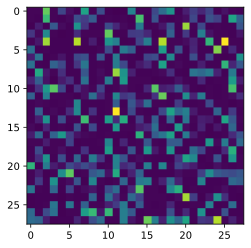

In [42]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(64, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 784)
  

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    return torch.tanh(x)

gnet = generator()
y = gnet(torch.randn(10, 64))
print(y.shape)
print(y[0, :].shape)
print(type(y[0].detach()))
plt.imshow(y[0, :].detach().squeeze().view(28, 28))

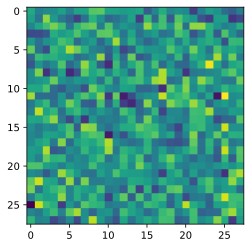

In [56]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

In [58]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [30]:
torch.randint?

In [32]:
print(dataT.shape)
torch.randint(dataT.shape[0], (10, ))

torch.Size([20000, 784])


tensor([19237, 11761, 19455,  6044,  2962,  2638, 11551, 13061, 17595,  6800])

In [33]:
torch.ones?

In [36]:
losses = torch.zeros(10, 2)
print(losses)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


In [61]:
# this cell takes ~3 mins with 50k epochs
num_epochs = 50000

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) # disDecs = discriminator decisions

for epochi in range(num_epochs):
    
  # create minibatches of REAL and FAKE images 
  randidx     = torch.randint(dataT.shape[0],(batchsize,))
  real_images = dataT[randidx,:].to(device)
  fake_images = gnet( torch.randn(batchsize,64).to(device) ) # output of generator


  # labels used for real and fake images
  real_labels = torch.ones(batchsize,1).to(device)
  fake_labels = torch.zeros(batchsize,1).to(device)



  ### ---------------- Train the discriminator ---------------- ###

  # forward pass and loss for REAL pictures
  pred_real   = dnet(real_images)              # REAL images into discriminator
  d_loss_real = lossfun(pred_real,real_labels) # all labels are 1
  
  # forward pass and loss for FAKE pictures
  pred_fake   = dnet(fake_images)              # FAKE images into discriminator
  d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0
  
  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake
  losses[epochi,0]  = d_loss.item()
  disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

  # backprop
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()

  
  

  ### ---------------- Train the generator ---------------- ###

  # create fake images and compute loss
  fake_images = gnet( torch.randn(batchsize,64).to(device) )
  pred_fake   = dnet(fake_images)
  
  # compute and collect loss and accuracy
  g_loss = lossfun(pred_fake,real_labels)
  losses[epochi,1]  = g_loss.item()
  disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()
  
  # backprop
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()

  
  # print out a status message
  if (epochi+1)%500==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)
  

Finished epoch 50000/50000

In [62]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

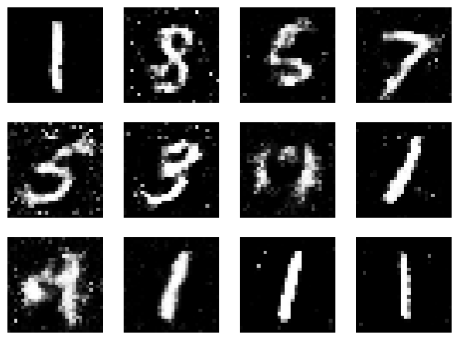

In [63]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()